<a href="https://colab.research.google.com/github/ARJUN108-verma/LangGraph/blob/main/12_The_StateSnapshot_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The StateSnapshot class:-

Set the OpenAI API Key as an Environment Variable

In [5]:
!pip install mypy_ipython

  Preparing metadata (setup.py) ... done
  Using cached incremental-24.7.2-py3-none-any.whl.metadata (8.1 kB)
Using cached incremental-24.7.2-py3-none-any.whl (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.6 MB/s eta 0:00:00
  Created wheel for mypy_ipython: filename=mypy_ipython-20.8.0-py3-none-any.whl size=4334 sha256=97be6f49994c9d67a171cb69a1f6bbecb9856c990149656752e711b05339d77d
  Stored in directory: /root/.cache/pip/wheels/8b/85/fe/8080788fd3e0d264fcb6fc64e155a55f80a2ab5b96c900ddf6
Successfully built mypy_ipython


In [6]:
%load_ext dotenv
%dotenv
%load_ext mypy_ipython

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
cannot find .env file


Import Relevant Classes and Functions

In [8]:
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 15.4 MB/s eta 0:00:00


In [10]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 2.3 MB/s eta 0:00:00


In [11]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage, RemoveMessage
from langgraph.checkpoint.memory import InMemorySaver

Define the State

In [12]:
class State(MessagesState):
    summary: str

Define the Nodes

In [14]:
chat = ChatOpenAI(api_key= "Enter Api key",
                  model = "gpt-4o",
                  seed = 365,
                  temperature = 0,
                  max_completion_tokens = 100)

In [15]:
def ask_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_question:")

    question = "What is your question?"
    print(question)

    return State(messages = [AIMessage(question), HumanMessage(input())])

In [16]:
def chatbot(state: State) -> State:

    print(f"\n-------> ENTERING chatbot:")

    system_message = f'''
    Here's a quick summary of what's been discussed so far:
    {state.get("summary", "")}

    Keep this in mind as you answer the next question.
    '''

    response = chat.invoke([SystemMessage(system_message)] + state["messages"])
    response.pretty_print()

    return State(messages = [response])

In [17]:
def summarize_messages(state: State) -> State:
    print(f"\n-------> ENTERING summarize_messages:")

    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"

    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below.
Build upon the previous summary rather than repeating it,
so that the result reflects the most recent context and developments.
Respond only with the summary.

Previous Summary:
{state.get("summary", "")}

New Conversation:
{new_conversation}
'''

    print(summary_instructions)

    summary = chat.invoke([HumanMessage(summary_instructions)])

    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]

    return State(messages = remove_messages, summary = summary.content)

Define the Graph

In [18]:
graph = StateGraph(State)

In [19]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("summarize_messages", summarize_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "summarize_messages")
graph.add_edge("summarize_messages", END)

In [20]:
checkpointer = InMemorySaver()
graph_compiled = graph.compile(checkpointer)

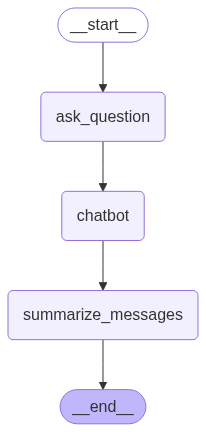

In [21]:
graph_compiled

In [22]:
config1 = {"configurable": {"thread_id": "1"}}
config2 = {"configurable": {"thread_id": "2"}}

In [ ]:
graph_compiled.invoke(State(), config2)


-------> ENTERING ask_question:
What is your question?


In [ ]:
graph_states = [i for i in graph_compiled.get_state_history(config1)]

In [ ]:
graph_states

In [ ]:
for i in graph_states[::-1]:
    print(f'''
Messages: {i.values["messages"]}
Summary: {i.values.get("summary", "")}
Next: {i.next}
Step: {i.metadata["step"]}''')